In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from emnist import extract_training_samples, extract_test_samples
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

#### IMPORTING AND COLLECTING DATA

In [2]:
x_train_d, y_train_d = extract_training_samples('digits')
x_test_d, y_test_d = extract_test_samples('digits')

train_data_generator = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

data_dir = pathlib.Path('tanda_baca')
train_ds = train_data_generator.flow_from_directory(
  data_dir,
  subset="training",
  seed=123,
  target_size=(28, 28),
  class_mode="categorical",
  batch_size=1,
  color_mode="grayscale")

val_ds = train_data_generator.flow_from_directory(
  data_dir,
  subset="validation",
  seed=123,
  target_size=(28, 28),
  class_mode="categorical",
  batch_size=1,
  color_mode="grayscale")

batch_index = 0
x_train_s = []
y_train_s = []
while batch_index <= train_ds.batch_index:
    data = train_ds.next()
    x_train_s.append(data[0])
    y_train_s.append(1)
    batch_index += 1
    
batch_index = 0
x_test_s = []
y_test_s = []
while batch_index <= val_ds.batch_index:
    data = val_ds.next()
    x_test_s.append(data[0])
    y_test_s.append(1)
    batch_index += 1
    
x_train_s, x_test_s = np.array(x_train_s), np.array(x_test_s)
y_train_s, y_test_s = np.array(y_train_s), np.array(y_test_s)

Found 488 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [3]:
y_test_s.shape

(120,)

#### ADDING IMAGE CHANNEL DIMENSION

In [4]:
x_train_s = x_train_s.reshape(x_train_s.shape[0], 28, 28, 1)
x_test_s = x_test_s.reshape(x_test_s.shape[0], 28, 28, 1)

In [5]:
y_test_d.shape

(40000,)

In [6]:
Counter(y_train_d)

Counter({8: 24000,
         9: 24000,
         6: 24000,
         3: 24000,
         7: 24000,
         1: 24000,
         0: 24000,
         4: 24000,
         5: 24000,
         2: 24000})

#### SHUFFLING DIGIT DATASET AND SPLITTING FOR BALANCING PURPOSES

In [6]:
idx = [x for x in range(len(y_train_d))]
np.random.shuffle(idx)

idx_test = [x for x in range(len(y_test_d))]
np.random.shuffle(idx_test)

y_train_d_new, y_test_d_new = np.array([0 for x in y_train_d]), np.array([0 for x in y_test_d])
y_train_s_new, y_test_s_new = np.array([1 for x in y_train_s]), np.array([1 for x in y_test_s])

split_x_train_d, split_y_train_d = x_train_d[idx[:488]], y_train_d_new[idx[:488]]
split_x_test_d, split_y_test_d = x_test_d[idx_test[:120]], y_test_d_new[idx_test[:120]]

#### ADDING LAST DIMENSION AND NORMALIZING

In [7]:
split_x_train_d, split_x_test_d = split_x_train_d.reshape(split_x_train_d.shape[0], 28, 28, 1), split_x_test_d.reshape(split_x_test_d.shape[0], 28, 28, 1)
split_x_train_d, split_x_test_d = split_x_train_d/255.0, split_x_test_d/255.0

#### COMBINING DATASETS

In [8]:
comb_x_train = np.concatenate((x_train_s, split_x_train_d), axis=0)
comb_y_train = np.concatenate((y_train_s_new, split_y_train_d), axis=0)

comb_x_test = np.concatenate((x_test_s, split_x_test_d), axis=0)
comb_y_test = np.concatenate((y_test_s_new, split_y_test_d), axis=0)

In [9]:
comb_y_test[68]

1

#### MODEL BUILDING & TRAINING

In [10]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=comb_x_train.shape[1:], activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation="relu"),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])

model.compile(optimizer = "adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 3872)              0         
                                                                 
 dense (Dense)               (None, 32)                123936    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                        

In [11]:
model.fit(comb_x_train, comb_y_train, epochs=20, validation_data=(comb_x_test, comb_y_test))

Epoch 1/20
31/31 [==============================] - 3s 10ms/step - loss: 0.1604 - acc: 0.9529 - val_loss: 2.7761e-04 - val_acc: 1.0000
Epoch 2/20
31/31 [==============================] - 0s 4ms/step - loss: 9.0807e-04 - acc: 1.0000 - val_loss: 4.6789e-06 - val_acc: 1.0000
Epoch 3/20
31/31 [==============================] - 0s 4ms/step - loss: 3.1588e-04 - acc: 1.0000 - val_loss: 1.8560e-06 - val_acc: 1.0000
Epoch 4/20
31/31 [==============================] - 0s 4ms/step - loss: 7.6046e-05 - acc: 1.0000 - val_loss: 1.2003e-06 - val_acc: 1.0000
Epoch 5/20
31/31 [==============================] - 0s 4ms/step - loss: 2.9920e-04 - acc: 1.0000 - val_loss: 6.8823e-07 - val_acc: 1.0000
Epoch 6/20
31/31 [==============================] - 0s 4ms/step - loss: 8.7695e-05 - acc: 1.0000 - val_loss: 4.5575e-07 - val_acc: 1.0000
Epoch 7/20
31/31 [==============================] - 0s 4ms/step - loss: 7.8745e-04 - acc: 1.0000 - val_loss: 6.2608e-04 - val_acc: 1.0000
Epoch 8/20
31/31 [===================

In [12]:
from collections import Counter

Counter(comb_y_train)

Counter({1: 488, 0: 488})

1/1 [==============================] - 0s 87ms/step
[[1.]]


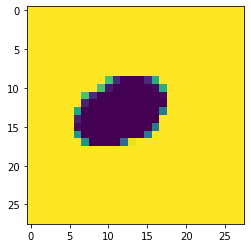

In [13]:
res = model.predict(np.array(comb_x_test[68]).reshape(1, 28, 28, 1))
print(np.round(res))

plt.imshow(np.array(comb_x_test[68]))

In [14]:
model.save('model\digit_symb.h5')